### Entranamiento / Evaluación

In [384]:
%pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.python.org/simple
Note: you may need to restart the kernel to use updated packages.


#### 💪 Training

In [385]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [386]:
proc_data_path='../data/processed/road_traffic_accidents_dataset_proc.csv'
train_data = pd.read_csv(proc_data_path)


In [387]:
x = train_data.drop('accident_severity', axis=1)
y = train_data['accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)


In [388]:
print('Train x shape:', xtrain.shape)
print('Train y shape:', ytrain.shape)
print('Test x shape:', xtest.shape)
print('Test y shape:', ytest.shape)

xtrain.to_csv('../data/train/xtrain.csv', index=False)
ytrain.to_csv('../data/train/ytrain.csv', index=False)
xtest.to_csv('../data/test/xtest.csv', index=False)
ytest.to_csv('../data/test/ytest.csv', index=False)


Train x shape: (2311, 236)
Train y shape: (2311,)
Test x shape: (578, 236)
Test y shape: (578,)


In [389]:
models={"LogisticRegression":LogisticRegression(max_iter=1000),
        "DecisionTreeClassifier":DecisionTreeClassifier(),
        "KNeighborsClassifier":KNeighborsClassifier(),
        "RandomForestClassifier":RandomForestClassifier(),
        # "AdaBoostClassifier":AdaBoostClassifier(),
        # "GradientBoostingClassifier":GradientBoostingClassifier(),
        }

In [390]:
# models,x,y,scaleFlag=0,1,2
def modelAccuracy(models,x,y,scaleFlag):
    #train/Test
    xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.2,random_state=42)
    acc_result={}
    for name,model in models.items():
        #pipeline
        #1.Transformer -> 2.Model
        if(scaleFlag==1):
            model_pipeline=Pipeline([('MinMaxScler',MinMaxScaler()),('model',model)])
        elif(scaleFlag==2):
             model_pipeline=Pipeline([('StandardScaler',StandardScaler()),('model',model)])
        else:
            model_pipeline=Pipeline([('model',model)])
        #training/testing on model pipeline
        model_fit=model_pipeline.fit(xtrain,ytrain)
        ypred=model_fit.predict(xtest)
        acc=accuracy_score(ytest,ypred)
        print("The Accuracy for ",name," is :",acc)
        acc_result[name]=acc
    return acc_result

In [391]:
def bestModel(result):
    high=0
    for name,acc in result.items():
        if acc>high:
            high=acc
            model_name=name
    print("Best Model is ",model_name," with accuaracy =>",high)

In [392]:
def bestParams(model,param,xtrain,ytrain):
    #cv
    cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=3)
    grid_cv=GridSearchCV(estimator=model,param_grid=param,cv=cv,scoring="f1_weighted")
    res=grid_cv.fit(xtrain,ytrain)
    print("Best Parameters are ",res.best_params_)
    print("Best Accuracy is ",res.best_score_)

In [393]:
acc_result=modelAccuracy(models,x,y,0)

The Accuracy for  LogisticRegression  is : 0.8529411764705882
The Accuracy for  DecisionTreeClassifier  is : 0.7577854671280276
The Accuracy for  KNeighborsClassifier  is : 0.8667820069204152
The Accuracy for  RandomForestClassifier  is : 0.8719723183391004


In [394]:
bestModel(acc_result)

Best Model is  RandomForestClassifier  with accuaracy => 0.8719723183391004


In [395]:
model=RandomForestClassifier()
params={"n_estimators" : [100,200],
        "criterion" : ["gini","entropy"]
        }
# bestParams(model,params,xtrain,ytrain)

In [396]:
#retrain the model with best parameters
model=RandomForestClassifier(criterion="entropy",n_estimators=200)
model.fit(xtrain,ytrain)
ypred=model.predict(xtest)


In [397]:
#export the model
import pickle
pickle.dump(model,open("../models/road_traffic_accidents_model.pkl","wb"))


Accuracy: 0.870242214532872
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00        67
           2       0.87      1.00      0.93       503

    accuracy                           0.87       578
   macro avg       0.29      0.33      0.31       578
weighted avg       0.76      0.87      0.81       578



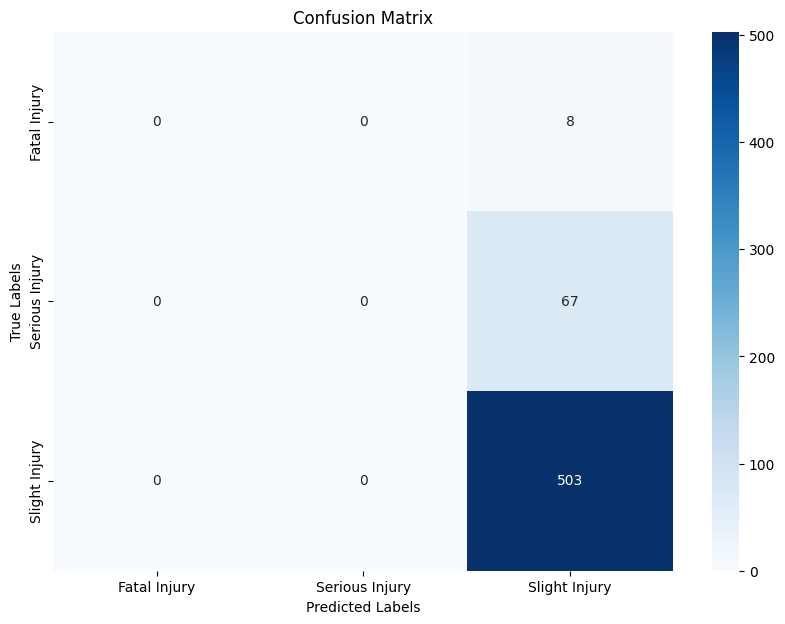

In [398]:
#Final Evaluation

# Print accuracy
print("Accuracy:", accuracy_score(ytest, ypred))

# Print classification report with zero_division parameter
print("Classification Report:")
print(classification_report(ytest, ypred, zero_division=0))  # Set zero_division to 0

# Generate and plot confusion matrix
cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'], yticklabels=['Fatal Injury', 'Serious Injury', 'Slight Injury'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### 🎯 Predict